# Web-scraping: сбор данных из баз данных и интернет-источников

*Алла Тамбовцева, НИУ ВШЭ*

## Более продвинутый парсинг с BeautifulSoup

Импортируем необходимые модули и библиотеки:

In [1]:
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

### Часть 1: чуть-чуть про кодировки

Подключаемся к странице древнего [сайта-архива](https://filmiki.arjlover.net/filmiki/) с детскими (преимущественно, советскими) фильмами:

In [2]:
page01 = requests.get("https://filmiki.arjlover.net/filmiki/")
soup01 = BeautifulSoup(page01.text)

Давайте найдём на этой странице таблицу, в которой сохранены названия фильмов и ссылки для скачивания.

In [3]:
t = soup01.find_all("table")[3]

Преобразуем фрагмент кода с тэгом `<table>` сначала в строку, а затем – в датафрейм с помощью `pandas`:

In [5]:
df = pd.read_html(str(t))[0]
df.head()

,N,Íàçâàíèå,Ðàçìåð,Êàðòèíêà,Äëèò-òü,Ñêà÷àòü
0,1.0,31 èþíÿ (1/2),1206.986.752,720x528,01:04:29,http ed2k torrent
1,2.0,31 èþíÿ (2/2),1288.005.632,720x528,01:05:57,http ed2k torrent
2,3.0,4:0 â ïîëüçó Òàíå÷êè,734.666.752,576x336,01:23:49,http ed2k torrent
3,4.0,"Àâòîìîáèëü, ñêðèïêà è ñîáàêà Êëÿêñà",1465.978.880,720x368,01:36:00,http ed2k torrent
4,5.0,À åñëè ýòî ëþáîâü?,1446.512.640,640x480,01:36:06,http ed2k torrent


Проблема: текст в таблице не совсем корректно считывается, вместо букв крокозябры. Эта проблема связана с тем, что кодировка, которую функция `.get()` выбрала здесь по умолчанию, не соответствует той, которая нам нужна. Посмотрим на неё:

In [6]:
page01.encoding

'ISO-8859-1'

Изменим её:

In [7]:
page01.encoding='windows-1251'

Попробуем повторить те же действия:

In [8]:
soup01 = BeautifulSoup(page01.text)
table = soup01.find_all("table")[3]

Выглядит получше! Давайте еще раз вспомним, как превращать код HTML в датафрейм `pandas`:

In [9]:
df = pd.read_html(str(table))[0]
df.head()

,N,Название,Размер,Картинка,Длит-ть,Скачать
0,1.0,31 июня (1/2),1206.986.752,720x528,01:04:29,http ed2k torrent
1,2.0,31 июня (2/2),1288.005.632,720x528,01:05:57,http ed2k torrent
2,3.0,4:0 в пользу Танечки,734.666.752,576x336,01:23:49,http ed2k torrent
3,4.0,"Автомобиль, скрипка и собака Клякса",1465.978.880,720x368,01:36:00,http ed2k torrent
4,5.0,А если это любовь?,1446.512.640,640x480,01:36:06,http ed2k torrent


Минутка священного рандома – вдруг пригодится:

In [10]:
import random 

# преобразуем столбец с названием в список
# случайным образом дергаем 3 фильма из списка

L = list(df["Название"])
random.sample(L, 3)

['Два капитана (6/6)', 'Тигры на льду', 'Валькины паруса']

### Часть 2: дополнительные опции в BeautifulSoup или обходим капчи

Итак, мы все-таки ограбим Кинопоиск! Попробуем сначала действовать как обычно:

In [11]:
url = "https://www.kinopoisk.ru/film/44587/"
page02 = requests.get(url)

Результат нас вряд ли устроит:

In [12]:
page02.text

'<body></body><script nonce=\'e3622099e83b24985464de939ba28f52\'>var it = {"host":"https:\\u002F\\u002Fsso.kinopoisk.ru\\u002Finstall?uuid=89c132cf-4b90-476f-b8a1-a1fd87835024","retpath":"https:\\u002F\\u002Fwww.kinopoisk.ru\\u002F\\u002Fapi\\u002Fprofile-pending\\u002F?retpath=https%3A%2F%2Fwww.kinopoisk.ru%2Ffilm%2F44587%2F"};(function() { var form = document.createElement(\'form\'); var element1 = document.createElement(\'input\'); var element2 = document.createElement(\'input\'); element1.name = \'retpath\'; element1.type = \'hidden\'; element1.value = it.retpath; form.appendChild(element1); element2.name = \'container\'; element2.type = \'hidden\'; element2.value = \'1682598050.10135558.WxmdRs4mjWbZqxTm.U_3iLc8hApAzgwPVaSGczVbg4-Miomka5YpEVyv-JDe6P0IUMZOhPPYc1NXd6GH2vN-NgqmXY7oI-_cOIrpKWOu1vvhYYaqz-0CATc5nCX_ohly0KOwJH8VNYdBFg1_W72YAp5KMg00RO4XfXDUq2C-8FnBqvP0qQ_dKP6bI02-CwdGasxsqE_Kid_i7glaHrv10mzzO17trMjcajq3ZZjHzYP8atjZiTlaOKj42YD6W7lJuv3eEsdlmWpZILG2gVWG6bS93k-ALhu9NszsvFtgC2U

Посмотрим на страницу, которая открывается при попытке сгрузить информацию через `get()`, оно того стоит (если у вас вылезала капча, она делала это на прекрасном фоне с белым шумом):

In [13]:
# создаем новый файл HTML, w – от write, режим записи
# декодируем, чтобы был текст на кириллице
# вписываем содержимое в файл
# закрываем файл для сохранения изменений

check = open('check.html', 'w')
check.write(page02.text)
check.close()

Теперь можно посмотреть на записанный HTML-файл *check.html*, он создан и лежит рядом с текущим ipynb-файлом.

Зайдем в инструменты разработчика и найдем опцию, которая добавляется при обработке запроса к странице, когда мы открываем ее в «ручном» режиме (кликаем правой клаишей в Chrome, *Просмотреть код – Network*, далее кликаем куда-нибудь на странице, находим в окне действие *click*, открываем его и смотрим на опции во вкладке *Headers*, часть *Request headers*):

In [14]:
headers = {'user-agent':
           'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36'}

Учтем эту опцию при загрузке страницы:

In [15]:
page02 = requests.get("https://www.kinopoisk.ru/film/44587/", headers = headers)
soup02 = BeautifulSoup(page02.text)

Ура! Исходный код страницы получен, можно его парсить.

Если не сработало, можно попробовать учесть больше опций (скопируйте свои значения из браузера), не только аргумент `user-agent`:

In [17]:
headers = {
    'user-agent':
           'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36',
    'cookie' : 'yandexuid=6716840761632947288; yuidss=6716840761632947288; amcuid=2904602101652300459; _ym_uid=1653329391355567937; yandex_gid=213; ymex=1701382659.yrts.1669846659#1978614381.yrtsi.1663254381; skid=2461002541672938768; gdpr=0; yp=1701118684.pgp.1_27826359#1671432954.szm.2:1440x900:1440x821#1670914554.ln_tp.true#1988317406.udn.cDphbGxhdGFtYm92QGdtYWlsLmNvbQ%3D%3D#1988317406.multib.1; yandex_login=tambovtseva.alla; yashr=1892815801674070179; i=hgr6qaPOwyPfnuD2Q3HfuzFAv5TvCO6u3wt8zM6iE68DhYDLUNZ3J7VqfUb9ThaQtNkys0EXFJs1fzeykMCxRKdsAFQ=; _ym_d=1678659743; is_gdpr=0; is_gdpr_b=CI7aQhDQsgEoAg==; Session_id=3:1682441688.5.0.1672957308794:yMdmvFh034wAQKWQaCECKg:1.1.2:1|1739464787.98.2.1:330222651.2:98|3:10268939.244094.ogkzRe39ULIB05hE_sb-K5jAfXE; sessionid2=3:1682441688.5.0.1672957308794:yMdmvFh034wAQKWQaCECKg:1.1.2:1|1739464787.98.2.1:330222651.2:98|3:10268939.244094.fakesign0000000000000000000; ys=udn.cDp0YW1ib3Z0c2V2YS5hbGxh#c_chck.1623918946; bh=EkEiQ2hyb21pdW0iO3Y9IjExMiIsICJHb29nbGUgQ2hyb21lIjt2PSIxMTIiLCAiTm90OkEtQnJhbmQiO3Y9Ijk5IhoFIng4NiIiECIxMTIuMC41NjE1LjEzNyIqAj8wOgcibWFjT1MiQgkiMTAuMTMuNiJKBCI2NCJSXCJDaHJvbWl1bSI7dj0iMTEyLjAuNTYxNS4xMzciLCJHb29nbGUgQ2hyb21lIjt2PSIxMTIuMC41NjE1LjEzNyIsIk5vdDpBLUJyYW5kIjt2PSI5OS4wLjAuMCIi',
}

page02 = requests.get("https://www.kinopoisk.ru/film/44587/", headers = headers)
soup02 = BeautifulSoup(page02.text)

**NB.** Решение не самое стабильное, зависит от сети и настроек браузера, иногда бывает наоборот: безо всяких опций Кинопоиск отдает исходный с обычным `requests.get()` без дополнительных параметров, а с дополнительными `headers` все ломается. В общем, Selenium – наш друг :) Но для сайтов пороще часто без Selenium можно обойтись, выставив таким образом параметры запроса.

### Часть 3: продолжаем поиски

Попытаемся найти описание фильма, которое начинается со слов *Художник-безумец*:

In [26]:
soup02.find("meta", {"name" : "description"})

<meta content="Художник-безумец принимает Марию за погибшую натурщицу. Авангардный советский хоррор с музыкой Сергея Курехина. Смотрите онлайн на Кинопоиске." data-tid="57f72b5" name="description"/>

Или воспользуемся регулярными выражениями:

In [27]:
description = re.findall('"shortDescription":"(.+?)",', text)[0]
print(description)

Художник-безумец принимает Марию за погибшую натурщицу. Авангардный советский хоррор с музыкой Сергея Курехина


Теперь найдем раздел, который содержит большую часть информации о фильме (заголовок *О фильме*) и сохраним фрагмент кода в переменную `tab`:

In [28]:
tab = soup02.find("div", {"data-test-id" : "encyclopedic-table"})

Найдем все элементы внутри, извлечем из них текст и создадим словарь с информацией о фильме:

In [29]:
children = list(tab.children)
info = [list(child.strings) for child in children]

info_dict = {}
for part in info:
    key = part[0]
    value = "".join(part[1:])
    info_dict[key] = value
    
info_dict

{'Год производства': '1988',
 'Страна': 'СССР',
 'Жанр': 'ужасы, фэнтези, драма, детективслова',
 'Слоган': '—',
 'Режиссер': 'Олег Тепцов',
 'Сценарий': 'Юрий Арабов, Александр Грин',
 'Директор фильма': 'Олег Тепцов, Вениамин Кутиков',
 'Оператор': 'Анатолий Лапшов',
 'Композитор': 'Сергей Курехин',
 'Художник': 'Наталья Васильева, Лариса Конникова',
 'Монтаж': 'Ирина Гороховская',
 'Зрители': '3.3 млн , ...',
 'Премьера в мире': '18 мая 1990, ...',
 'Возраст': '16+',
 'Время': '109 мин. / 01:49'}

Найдем ссылку, которая ведет нас к подробной информации о рейтинге фильма, и сохраним ее в переменную `link`:

In [30]:
link = soup02.find("a", {"class" : "film-rating-value styles_rootLink__mm0kW"}).get("href")

Сделаем ссылку полной, перейдем по ней:

In [31]:
link_full = "https://www.kinopoisk.ru" + link
print(link_full)

https://www.kinopoisk.ru/film/44587/votes/


Начинаем все сначала:

In [33]:
page03 = requests.get(link_full, headers = headers)
soup03 = BeautifulSoup(page03.text)

Найдем и сохраним рейтинг фильма и количество оценок:

In [34]:
rating = soup03.find("span", {"class" : "rating_ball"}).text.replace("*", "").strip()
count = soup03.find("span", {"class" : "ratingCount"}).text.replace("**", "").strip()

### Часть 4: забираем данные из json-файла и воспроизводим графики

А теперь - самое интересное! Заберем данные, которые используются для построения графиков на этой странице, чтобы самим строить графики не хуже (а то и лучше). Остановимся пока на тех данных, которые легли в основу круговой диаграммы.

Данные хранятся в json-файле, ссылка на который доступна внутри кода JavaScript в исходном коде страницы. Для универсальности и надежности превратим `soup03` в обычную строку и вновь воспользуемся регулярными выражениями, как раньше:

In [35]:
text03 = str(soup03)
re.findall("dataURI:(.+),", text03)

[" 'https://kinopoisk-fvs.s3.yandex.net/films/44587/value-stats.json'",
 " '/charts/votes/44587/last_votes.json'"]

In [36]:
json_link = re.findall("dataURI:(.+),", text03)[0].replace("'", "").strip()
print(json_link)

https://kinopoisk-fvs.s3.yandex.net/films/44587/value-stats.json


Переходим на страницу с этим json-файлом и забираем данные:

In [37]:
page04 = requests.get(json_link) # тут уже без капчи, кстати

In [38]:
page04.json()

[{'value': 242, 'title': '1', 'out': None},
 {'value': 140, 'title': '2', 'out': None},
 {'value': 212, 'title': '3', 'out': None},
 {'value': 305, 'title': '4', 'out': None},
 {'value': 733, 'title': '5', 'out': None},
 {'value': 1258, 'title': '6', 'out': None},
 {'value': 2201, 'title': '7', 'out': 'true'},
 {'value': 2135, 'title': '8', 'out': None},
 {'value': 1136, 'title': '9', 'out': None},
 {'value': 1633, 'title': '10', 'out': None}]

In [40]:
data = page04.json()

Заберем значения оценок (`values`) и соответствующие им частоты (`freqs`):

In [41]:
freqs = [d["value"] for d in data]
values = [d["title"] for d in data]

Импортируем модуль для построения графиков:

In [42]:
from matplotlib import pyplot as plt

Вместо круговой диаграммы строим столбиковую диаграмму:

<BarContainer object of 10 artists>

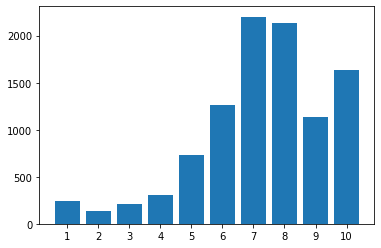

In [43]:
plt.bar(values, freqs)

Добавляем свои цвета для столбцов – сохраняем их в виде списка `colors`:

In [44]:
colors = ["red"] * 3 + ["orange"] * 2 + ["yellow"] * 2 + ["green"] * 3
colors

['red',
 'red',
 'red',
 'orange',
 'orange',
 'yellow',
 'yellow',
 'green',
 'green',
 'green']

Обновляем график (да, цвета пока дикие):

<BarContainer object of 10 artists>

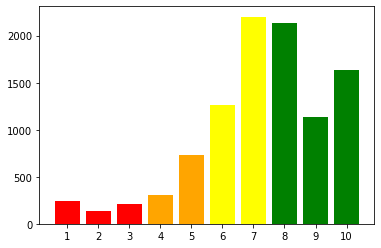

In [45]:
plt.bar(values, freqs, color = colors)